In [1]:
import argparse
import logging
import sys
import threading
import time
from datetime import datetime, timedelta

import numpy as np
import uhd
import matplotlib.pyplot as plt

CLOCK_TIMEOUT = 1000  # 1000mS timeout for external clock locking
INIT_DELAY = 0.05  # 50mS initial delay before transmit

In [2]:
def get_args(
    args="",
    duration=10.0,
    rx_subdev=None,
    tx_subdev=None,
    rx_rate=None,
    tx_rate=None,
    rx_otw="sc16",
    tx_otw="sc16",
    rx_cpu="fc32",
    tx_cpu="fc32",
    rx_stream_args="",
    tx_stream_args="",
    ref=None,
    pps=None,
    random=False,
    channels=[0],
    rx_channels=None,
    tx_channels=None
):
    """Get the arguments for benchmark_rate in notebook or script mode."""
    
    class Args:
        pass
    
    options = Args()
    
    options.args = args
    options.duration = duration
    options.rx_subdev = rx_subdev
    options.tx_subdev = tx_subdev
    options.rx_rate = rx_rate
    options.tx_rate = tx_rate
    options.rx_otw = rx_otw
    options.tx_otw = tx_otw
    options.rx_cpu = rx_cpu
    options.tx_cpu = tx_cpu
    options.rx_stream_args = rx_stream_args
    options.tx_stream_args = tx_stream_args
    options.ref = ref
    options.pps = pps
    options.random = random
    options.channels = channels
    options.rx_channels = rx_channels
    options.tx_channels = tx_channels
    
    return options


In [3]:
class LogFormatter(logging.Formatter):
    """Log formatter which prints the timestamp with fractional seconds."""

    @staticmethod
    def pp_now():
        """Returns a formatted string containing the time of day."""
        now = datetime.now()
        return "{:%H:%M}:{:05.2f}".format(now, now.second + now.microsecond / 1e6)
        # return "{:%H:%M:%S}".format(now)

    def formatTime(self, record, datefmt=None):  # noqa: N802
        """Return the Date in the specified format."""
        converter = self.converter(record.created)
        if datefmt:
            formatted_date = converter.strftime(datefmt)
        else:
            formatted_date = LogFormatter.pp_now()
        return formatted_date

In [4]:
global logger,rx_sig
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
console = logging.StreamHandler()
logger.addHandler(console)
formatter = LogFormatter(fmt="[%(asctime)s] [%(levelname)s] (%(threadName)-10s) %(message)s")
console.setFormatter(formatter)

In [5]:
def setup_ref(usrp, ref, num_mboards):
    """Setup the reference clock."""
    if ref == "mimo":
        if num_mboards != 2:
            logger.error(
                'ref = "mimo" implies 2 motherboards; ' "your system has %d boards", num_mboards
            )
            return False
        usrp.set_clock_source("mimo", 1)
    else:
        usrp.set_clock_source(ref)

    # Lock onto clock signals for all mboards
    if ref != "internal":
        logger.debug("Now confirming lock on clock signals...")
        end_time = datetime.now() + timedelta(milliseconds=CLOCK_TIMEOUT)
        for i in range(num_mboards):
            if ref == "mimo" and i == 0:
                continue
            is_locked = usrp.get_mboard_sensor("ref_locked", i)
            while (not is_locked) and (datetime.now() < end_time):
                time.sleep(1e-3)
                is_locked = usrp.get_mboard_sensor("ref_locked", i)
            if not is_locked:
                logger.error("Unable to confirm clock signal locked on board %d", i)
                return False
    return True


def setup_pps(usrp, pps, num_mboards):
    """Setup the PPS source."""
    if pps == "mimo":
        if num_mboards != 2:
            logger.error(
                'ref = "mimo" implies 2 motherboards; ' "your system has %d boards", num_mboards
            )
            return False
        # make mboard 1 a slave over the MIMO Cable
        usrp.set_time_source("mimo", 1)
    else:
        usrp.set_time_source(pps)
    return True


def check_channels(usrp, args):
    """Check that the device has sufficient RX and TX channels available."""
    # Check RX channels
    if args.rx_rate:
        if args.rx_channels:
            rx_channels = args.rx_channels
        else:
            rx_channels = args.channels
        # Check that each channel specified is less than the number of total number of rx channels
        # the device can support
        dev_rx_channels = usrp.get_rx_num_channels()
        if not all(map((lambda chan: chan < dev_rx_channels), rx_channels)):
            logger.error("Invalid RX channel(s) specified.")
            return [], []
    else:
        rx_channels = []
    # Check TX channels
    if args.tx_rate:
        if args.tx_channels:
            tx_channels = args.tx_channels
        else:
            tx_channels = args.channels
        # Check that each channel specified is less than the number of total number of tx channels
        # the device can support
        dev_tx_channels = usrp.get_tx_num_channels()
        if not all(map((lambda chan: chan < dev_tx_channels), tx_channels)):
            logger.error("Invalid TX channel(s) specified.")
            return [], []
    else:
        tx_channels = []
    return rx_channels, tx_channels


def benchmark_rx_rate(usrp, rx_streamer, random, timer_elapsed_event, rx_statistics, rx_samples):
    """Benchmark the receive chain."""
    logger.info(
        "Testing receive rate {:.3f} Msps on {:d} channels".format(
            usrp.get_rx_rate() / 1e6, rx_streamer.get_num_channels()
        )
    )

    # Make a receive buffer
    num_channels = rx_streamer.get_num_channels()
    max_samps_per_packet = rx_streamer.get_max_num_samps()
    # TODO: The C++ code uses rx_cpu type here. Do we want to use that to set dtype?
    recv_buffer = np.empty((num_channels, max_samps_per_packet), dtype=np.complex64)
    metadata = uhd.types.RXMetadata()

    # Craft and send the Stream Command
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
    stream_cmd.stream_now = num_channels == 1
    stream_cmd.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + INIT_DELAY)
    rx_streamer.issue_stream_cmd(stream_cmd)

    # To estimate the number of dropped samples in an overflow situation, we need the following
    # On the first overflow, set had_an_overflow and record the time
    # On the next ERROR_CODE_NONE, calculate how long its been since the recorded time, and use the
    #   tick rate to estimate the number of dropped samples. Also, reset the tracking variables
    had_an_overflow = False
    last_overflow = uhd.types.TimeSpec(0)
    # Setup the statistic counters
    num_rx_samps = 0
    num_rx_dropped = 0
    num_rx_overruns = 0
    num_rx_seqerr = 0
    num_rx_timeouts = 0
    num_rx_late = 0

    rate = usrp.get_rx_rate()
    # Receive until we get the signal to stop
    while not timer_elapsed_event.is_set():
        if random:
            stream_cmd.num_samps = np.random.randint(1, max_samps_per_packet + 1, dtype=int)
            rx_streamer.issue_stream_cmd(stream_cmd)
        try:
            num_rx_samps += rx_streamer.recv(recv_buffer, metadata) * num_channels
            rx_samples.append(recv_buffer.copy())#.copy()
        except RuntimeError as ex:
            logger.error("Runtime error in receive: %s", ex)
            return

        # Handle the error codes
        if metadata.error_code == uhd.types.RXMetadataErrorCode.none:
            # Reset the overflow flag
            if had_an_overflow:
                had_an_overflow = False
                num_rx_dropped += (metadata.time_spec - last_overflow).to_ticks(rate)
        elif metadata.error_code == uhd.types.RXMetadataErrorCode.overflow:
            had_an_overflow = True
            # Need to make sure that last_overflow is a new TimeSpec object, not
            # a reference to metadata.time_spec, or it would not be useful
            # further up.
            last_overflow = uhd.types.TimeSpec(
                metadata.time_spec.get_full_secs(), metadata.time_spec.get_frac_secs()
            )
            # If we had a sequence error, record it
            if metadata.out_of_sequence:
                num_rx_seqerr += 1
            # Otherwise just count the overrun
            else:
                num_rx_overruns += 1
        elif metadata.error_code == uhd.types.RXMetadataErrorCode.late:
            logger.warning("Receiver error: %s, restarting streaming...", metadata.strerror())
            num_rx_late += 1
            # Radio core will be in the idle state. Issue stream command to restart streaming.
            stream_cmd.time_spec = uhd.types.TimeSpec(
                usrp.get_time_now().get_real_secs() + INIT_DELAY
            )
            stream_cmd.stream_now = num_channels == 1
            rx_streamer.issue_stream_cmd(stream_cmd)
        elif metadata.error_code == uhd.types.RXMetadataErrorCode.timeout:
            logger.warning("Receiver error: %s, continuing...", metadata.strerror())
            num_rx_timeouts += 1
        else:
            logger.error("Receiver error: %s", metadata.strerror())
            logger.error("Unexpected error on receive, continuing...")

    # Return the statistics to the main thread
    rx_statistics["num_rx_samps"] = num_rx_samps
    rx_statistics["num_rx_dropped"] = num_rx_dropped
    rx_statistics["num_rx_overruns"] = num_rx_overruns
    rx_statistics["num_rx_seqerr"] = num_rx_seqerr
    rx_statistics["num_rx_timeouts"] = num_rx_timeouts
    rx_statistics["num_rx_late"] = num_rx_late
    # After we get the signal to stop, issue a stop command
    rx_streamer.issue_stream_cmd(uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont))

def benchmark_tx_rate(usrp, tx_streamer, random, timer_elapsed_event, tx_statistics, tx_waveform):
    """Benchmark the transmit chain."""
    logger.info(
        "Testing transmit rate %.3f Msps on %d channels",
        usrp.get_tx_rate() / 1e6,
        tx_streamer.get_num_channels(),
    )

    # Make a transmit buffer
    num_channels = tx_streamer.get_num_channels()
    max_samps_per_packet = tx_streamer.get_max_num_samps()
    transmit_buffer = tx_waveform#np.zeros((num_channels, max_samps_per_packet), dtype=np.complex64)
    metadata = uhd.types.TXMetadata()
    metadata.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + INIT_DELAY)
    metadata.has_time_spec = bool(num_channels)

    # Setup the statistic counters
    num_tx_samps = 0
    num_timeouts_tx = 0
    # Transmit until we get the signal to stop
    if random:
        while not timer_elapsed_event.is_set():
            total_num_samps = np.random.randint(1, max_samps_per_packet + 1, dtype=int)
            num_acc_samps = 0
            while num_acc_samps < total_num_samps:
                num_tx_samps += tx_streamer.send(transmit_buffer, metadata) * num_channels
                num_acc_samps += min(
                    total_num_samps - num_acc_samps, tx_streamer.get_max_num_samps()
                )
    else:
        while not timer_elapsed_event.is_set():
            try:
                num_tx_samps_now = tx_streamer.send(transmit_buffer, metadata) * num_channels
                num_tx_samps += num_tx_samps_now
                if num_tx_samps_now == 0:
                    num_timeouts_tx += 1
                    if (num_timeouts_tx % 10000) == 1:
                        logger.warning("Tx timeouts: %d", num_timeouts_tx)
                metadata.has_time_spec = False

            except RuntimeError as ex:
                logger.error("Runtime error in transmit: %s", ex)
                return

    tx_statistics["num_tx_samps"] = num_tx_samps

    # Send a mini EOB packet
    metadata.end_of_burst = True
    tx_streamer.send(np.zeros((num_channels, 0), dtype=np.complex64), metadata)
    
def benchmark_tx_rate_async_helper(tx_streamer, timer_elapsed_event, tx_async_statistics):
    """Receive and process the asynchronous TX messages."""
    async_metadata = uhd.types.TXAsyncMetadata()

    # Setup the statistic counters
    num_tx_seqerr = 0
    num_tx_underrun = 0
    num_tx_timeouts = 0  # TODO: Not populated yet
    try:
        while not timer_elapsed_event.is_set():
            # Receive the async metadata
            if not tx_streamer.recv_async_msg(async_metadata, 0.1):
                continue

            # Handle the error codes
            if async_metadata.event_code == uhd.types.TXMetadataEventCode.burst_ack:
                return
            if async_metadata.event_code in (
                uhd.types.TXMetadataEventCode.underflow,
                uhd.types.TXMetadataEventCode.underflow_in_packet,
            ):
                num_tx_underrun += 1
            elif async_metadata.event_code in (
                uhd.types.TXMetadataEventCode.seq_error,
                uhd.types.TXMetadataEventCode.seq_error_in_packet,
            ):
                num_tx_seqerr += 1
            else:
                logger.warning(
                    "Unexpected event on async recv (%s), continuing.", async_metadata.event_code
                )
    finally:
        # Write the statistics back
        tx_async_statistics["num_tx_seqerr"] = num_tx_seqerr
        tx_async_statistics["num_tx_underrun"] = num_tx_underrun
        tx_async_statistics["num_tx_timeouts"] = num_tx_timeouts


def print_statistics(rx_statistics, tx_statistics, tx_async_statistics):
    """Print TRX statistics in a formatted block."""
    logger.debug("RX Statistics Dictionary: %s", rx_statistics)
    logger.debug("TX Statistics Dictionary: %s", tx_statistics)
    logger.debug("TX Async Statistics Dictionary: %s", tx_async_statistics)
    # Print the statistics
    statistics_msg = """Benchmark rate summary:
    Num received samples:     {}
    Num dropped samples:      {}
    Num overruns detected:    {}
    Num transmitted samples:  {}
    Num sequence errors (Tx): {}
    Num sequence errors (Rx): {}
    Num underruns detected:   {}
    Num late commands:        {}
    Num timeouts (Tx):        {}
    Num timeouts (Rx):        {}""".format(
        rx_statistics.get("num_rx_samps", 0),
        rx_statistics.get("num_rx_dropped", 0),
        rx_statistics.get("num_rx_overruns", 0),
        tx_statistics.get("num_tx_samps", 0),
        tx_async_statistics.get("num_tx_seqerr", 0),
        rx_statistics.get("num_rx_seqerr", 0),
        tx_async_statistics.get("num_tx_underrun", 0),
        rx_statistics.get("num_rx_late", 0),
        tx_async_statistics.get("num_tx_timeouts", 0),
        rx_statistics.get("num_rx_timeouts", 0),
    )
    logger.info(statistics_msg)

In [6]:
args = get_args(
    args="type=x300,addr=192.168.10.2",
    tx_rate=5e6,
    rx_rate=5e6,
    duration=10.0,
    channels=[0],
    random=True
)

# And now you can use options.tx_rate, options.rx_rate, options.args etc.
print(args.tx_rate)
print(args.rx_rate)

5000000.0
5000000.0


In [7]:
# Parameters
tx_rate = 5e6  # 5 MS/s
freq = 0.1e6     # 1 MHz tone
amplitude = 0.5
nsamples = 1000  # number of samples to send
rx_samples = []
# Generate a sine wave
t = np.arange(nsamples) / tx_rate
#tx_waveform = amplitude * np.exp(2j * np.pi * freq * t).astype(np.complex64)
tx_waveform = amplitude * np.cos(2* np.pi * freq * t).astype(np.complex64)

In [8]:
# Setup some argument parsing
if not (args.rx_rate or args.tx_rate):
    logger.error("Please specify --rx_rate and/or --tx_rate")

# Setup a usrp device
usrp = uhd.usrp.MultiUSRP(args.args)

usrp.set_rx_freq(uhd.types.TuneRequest(3.65e9))  # For RX at 2.4 GHz
usrp.set_tx_freq(uhd.types.TuneRequest(3.65e9))  # For TX at 2.4 GHz

if usrp.get_mboard_name() == "USRP1":
    logger.warning(
        "Benchmark results will be inaccurate on USRP1 due to insufficient features."
    )

# Always select the subdevice first, the channel mapping affects the other settings
if args.rx_subdev:
    usrp.set_rx_subdev_spec(uhd.usrp.SubdevSpec(args.rx_subdev))
if args.tx_subdev:
    usrp.set_tx_subdev_spec(uhd.usrp.SubdevSpec(args.tx_subdev))

logger.info("Using Device: %s", usrp.get_pp_string())

# Set the reference clock
if args.ref and not setup_ref(usrp, args.ref, usrp.get_num_mboards()):
    # If we wanted to set a reference clock and it failed, return
    logger.error("Setup_ref Failed")

# Set the PPS source
if args.pps and not setup_pps(usrp, args.pps, usrp.get_num_mboards()):
    # If we wanted to set a PPS source and it failed, return
    logger.error("Setup_pps Failed")
# At this point, we can assume our device has valid and locked clock and PPS

rx_channels, tx_channels = check_channels(usrp, args)
if not rx_channels and not tx_channels:
    # If the check returned two empty channel lists, that means something went wrong
    logger.error("Please specify --rx_channels and/or --tx_channels")
logger.info(
    "Selected %s RX channels and %s TX channels",
    rx_channels if rx_channels else "no",
    tx_channels if tx_channels else "no",
)

logger.info("Setting device timestamp to 0...")
# If any of these conditions are met, we need to synchronize the channels
if args.pps == "mimo" or args.ref == "mimo" or len(rx_channels) > 1 or len(tx_channels) > 1:
    usrp.set_time_unknown_pps(uhd.types.TimeSpec(0.0))
else:
    usrp.set_time_now(uhd.types.TimeSpec(0.0))

threads = []
# Make a signal for the threads to stop running
quit_event = threading.Event()
# Create a dictionary for the RX statistics
# Note: we're going to use this without locks, so don't access it from the main thread until
#       the worker has joined
rx_statistics = {}
# Spawn the receive test thread
if args.rx_rate:
    usrp.set_rx_rate(args.rx_rate)
    st_args = uhd.usrp.StreamArgs(args.rx_cpu, args.rx_otw)
    st_args.channels = rx_channels
    st_args.args = uhd.types.DeviceAddr(args.rx_stream_args)
    rx_streamer = usrp.get_rx_stream(st_args)
    rx_thread = threading.Thread(
        target=benchmark_rx_rate,
        args=(usrp, rx_streamer, args.random, quit_event, rx_statistics, rx_samples),
        name="bmark_rx_stream",
    )
    threads.append(rx_thread)
    rx_thread.start()

# Create a dictionary for the RX statistics
# Note: we're going to use this without locks, so don't access it from the main thread until
#       the worker has joined
tx_statistics = {}
tx_async_statistics = {}
# Spawn the transmit test thread
if args.tx_rate:
    usrp.set_tx_rate(args.tx_rate)
    st_args = uhd.usrp.StreamArgs(args.tx_cpu, args.tx_otw)
    st_args.channels = tx_channels
    st_args.args = uhd.types.DeviceAddr(args.tx_stream_args)
    tx_streamer = usrp.get_tx_stream(st_args)
    tx_thread = threading.Thread(
        target=benchmark_tx_rate,
        args=(usrp, tx_streamer, args.random, quit_event, tx_statistics, tx_waveform),
        name="bmark_tx_stream",
    )
    threads.append(tx_thread)
    tx_thread.start()

    tx_async_thread = threading.Thread(
        target=benchmark_tx_rate_async_helper,
        args=(tx_streamer, quit_event, tx_async_statistics),
        name="bmark_tx_helper",
    )
    threads.append(tx_async_thread)
    tx_async_thread.start()

# Sleep for the required duration
# If we have a multichannel test, add some time for initialization
if len(rx_channels) > 1 or len(tx_channels) > 1:
    args.duration += INIT_DELAY
time.sleep(args.duration)
# Interrupt and join the threads
logger.debug("Sending signal to stop!")
quit_event.set()
for thr in threads:
    thr.join()

print_statistics(rx_statistics, tx_statistics, tx_async_statistics)

[INFO] [UHD] linux; GNU C++ version 11.4.0; Boost_107400; UHD_4.6.0.0-3-g080b1baa
[11:08:48.38] [INFO] (MainThread) Using Device: Single USRP:
  Device: X-Series Device
  Mboard 0: X310
  RX Channel: 0
    RX DSP: 0
    RX Dboard: A
    RX Subdev: CBX-120 RX
  RX Channel: 1
    RX DSP: 1
    RX Dboard: B
    RX Subdev: CBX RX
  TX Channel: 0
    TX DSP: 0
    TX Dboard: A
    TX Subdev: CBX-120 TX
  TX Channel: 1
    TX DSP: 1
    TX Dboard: B
    TX Subdev: CBX TX

[INFO] [X300] X300 initialization sequence...
[INFO] [X300] Maximum frame size: 1472 bytes.
[INFO] [X300] Radio 1x clock: 200 MHz
[11:08:48.39] [INFO] (MainThread) Selected [0] RX channels and [0] TX channels
[11:08:48.39] [INFO] (MainThread) Setting device timestamp to 0...
[11:08:48.39] [INFO] (bmark_rx_stream) Testing receive rate 5.000 Msps on 1 channels
[11:08:48.40] [INFO] (bmark_tx_stream) Testing transmit rate 5.000 Msps on 1 channels
[11:08:58.41] [DEBUG] (MainThread) Sending signal to stop!
[11:08:58.42] [DEBUG] (

In [9]:
print(f"Received {len(rx_samples)} chunks of samples.")

# Example: concatenate them into one big array
all_rx_samples = np.concatenate(rx_samples)

print(f"Total received samples: {len(all_rx_samples)}")

# Now you can plot or analyze:

Received 137495 chunks of samples.
Total received samples: 137495


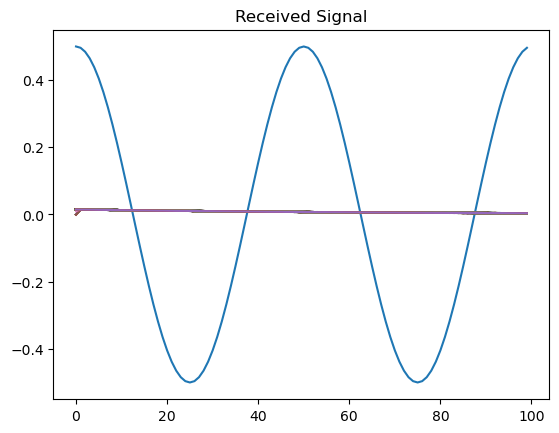

In [10]:
plt.plot(np.real(tx_waveform[:100]))
plt.plot(np.real(all_rx_samples[:100]))
plt.title('Received Signal')
plt.show()